In [1]:
import tensorflow
import numpy
import tensorflow.keras as tfk
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import math
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
import gc

In [2]:
img_size = 13
kernel_size=(img_size,img_size)
num_channels = 145
num_classes=12
latent_space_dim = 25
beta=1
alpha=0.01
LR_loss_factor=0.009
TH=0.5 #The threshold TH

In [3]:
!pip install libmr
import libmr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for libmr: filename=libmr-0.1.9-cp310-cp310-linux_x86_64.whl size=534021 sha256=3db42a5635aa93a7c1512b0168c2e08b6dcc32b90267dcd4144b1b6da8778cb0
  Stored in directory: /root/.cache/pip/wheels/8a/e0/45/ec5f4f802b034150d6f5735922408cc0278bf85582b2a1a954
Successfully built libmr


**Database:**
Botswana


In [4]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Download the database and save it in google drive (Only if not already existing)
import os.path

%cd /content/drive/My\ Drive/
if(os.path.exists('Amir')==False):
  !mkdir Amir
%cd Amir

if(os.path.isfile('Botswana.mat')==False):
  !wget http://www.ehu.es/ccwintco/uploads/7/72/Botswana.mat

if(os.path.isfile('Botswana_gt.mat')==False):
  !wget http://www.ehu.es/ccwintco/uploads/5/58/Botswana_gt.mat

/content/drive/My Drive
/content/drive/My Drive/Amir


In [ ]:
%cd /content/drive/My\ Drive/Amir
%ls

In [7]:
import scipy.io
botswana_gt = scipy.io.loadmat('Botswana_gt.mat')
botswana = scipy.io.loadmat('Botswana.mat')

In [8]:
# Normalize Database
from sklearn import preprocessing
import numpy as np

min_max_scaler = preprocessing.MinMaxScaler()

ascolumns_botswana = botswana['Botswana'].reshape(-1, num_channels)
t_botswana = min_max_scaler.fit_transform(ascolumns_botswana)
botswana['Botswana'] = t_botswana.reshape(botswana['Botswana'].shape)

#import pandas as pd
#pd.DataFrame(botswana['Botswana'][:,:,0])

In [9]:
source_gt=botswana_gt['Botswana_gt'][0:1111,0:128]
source_data=botswana['Botswana'][0:1111,0:128,:]

target_gt=botswana_gt['Botswana_gt'][0:1111,128:]
target_data=botswana['Botswana'][0:1111,128:,:]

In [10]:
# remove uncommon labels
import numpy as np

result=np.where(target_gt == 12)
target_gt[result]=100

result=np.where(target_gt == 13)
target_gt[result]=100


In [11]:
#Change the name of label 14 to 12
result=np.where(target_gt == 14)
target_gt[result]=12

result=np.where(source_gt == 14)
source_gt[result]=12

In [12]:
# Zero Padding
source_data=np.pad(source_data, ((6,6),(6,6),(0,0)), 'constant', constant_values= 0)
source_gt=np.pad(source_gt, ((6,6),(6,6)), 'constant', constant_values= 0)

target_data=np.pad(target_data, ((6,6),(6,6),(0,0)), 'constant', constant_values= 0)
target_gt=np.pad(target_gt, ((6,6),(6,6)), 'constant', constant_values= 0)


In [13]:
# Extract Patches:

source_patches=np.empty([1150,13,13,145], dtype=float)
source_patches_gt=np.empty([1150])
target_patches=np.empty([1649,13,13,145], dtype=float)
target_patches_gt=np.empty([1649])

unknown_patches=np.empty([449,13,13,145], dtype=float)
unknown_patches_gt=np.empty([449])

ind=np.where(np.logical_and(source_gt <100 , source_gt!=0))
for i in range(len(ind[0])):
  source_patches[i,:,:,:]=source_data[ind[0][i]-6:ind[0][i]+7,ind[1][i]-6:ind[1][i]+7,:]
  source_patches_gt[i]=source_gt[ind[0][i],ind[1][i]]

ind=np.where(np.logical_and(target_gt <100 , target_gt!=0))
tp_indexes=ind
for i in range(len(ind[0])):
  target_patches[i,:,:,:]=target_data[ind[0][i]-6:ind[0][i]+7,ind[1][i]-6:ind[1][i]+7,:]
  target_patches_gt[i]=target_gt[ind[0][i],ind[1][i]]

ind=np.where(target_gt ==100)  #unknown patches
uk_indexes=ind
for i in range(len(ind[0])):
  unknown_patches[i,:,:,:]=target_data[ind[0][i]-6:ind[0][i]+7,ind[1][i]-6:ind[1][i]+7,:]
  unknown_patches_gt[i]=target_gt[ind[0][i],ind[1][i]]

result=np.where(target_gt == 100)
target_gt[result]=13

In [14]:
target_patches_gt.shape

(1649,)

In [15]:
# Convert labels to OneHotEncoded type
import pandas as pd
source_patches_gt=pd.get_dummies(source_patches_gt)
source_patches_gt=source_patches_gt.to_numpy()

target_patches_gt=pd.get_dummies(target_patches_gt)
target_patches_gt=target_patches_gt.to_numpy()

unknown_patches_gt=pd.get_dummies(unknown_patches_gt)  #unknown patches
unknown_patches_gt=unknown_patches_gt.to_numpy()

source_patches_gt[0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [16]:
# All target (known and unknown) data:
target_all=numpy.concatenate((target_patches,unknown_patches),axis=0)
target_all_gt=numpy.concatenate((np.argmax(target_patches_gt,axis=1),12*np.ones(449)),axis=0)

In [17]:
# Shuffle Dataset

from sklearn.utils import shuffle
source_patches, source_patches_gt = shuffle(source_patches, source_patches_gt, random_state=42)
target_patches, target_patches_gt = shuffle(target_patches, target_patches_gt, random_state=42)

In [18]:
# Stratified Test/Train Splitting:

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
stratSplit.get_n_splits(source_patches, source_patches_gt)
for train_index, test_index in stratSplit.split(source_patches, source_patches_gt):
  print("Source TRAIN:", train_index, "Source TEST:", test_index)
  source_trainPatches, source_testPatches = source_patches[train_index], source_patches[test_index]
  source_trainPatches_gt, source_testPatches_gt = source_patches_gt[train_index], source_patches_gt[test_index]

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
stratSplit.get_n_splits(target_patches, target_patches_gt)
for train_index, test_index in stratSplit.split(target_patches, target_patches_gt):
  print("Target TRAIN:", train_index, "Target TEST:", test_index)
  target_trainPatches, target_testPatches = target_patches[train_index], target_patches[test_index]
  target_trainPatches_gt, target_testPatches_gt = target_patches_gt[train_index], target_patches_gt[test_index]


Source TRAIN: [359 280 552 ... 380 637 664] Source TEST: [ 121  506  317  491 1053  865  328 1096  582  303  509  164  189  405
  771  772  306  574 1089  268  624  203  801  651 1090  429  934  494
  726 1018  147  168  686  922  256  628 1095 1013  440   96 1029  647
  596  255 1007  400  507  744 1015  346  699  287  254   49 1025  319
   52  819  930  392  631 1055  775  682  489  825  513  308  918  586
   14  732  688   85  116  638 1139  963  325  847  998  792  842 1098
  425 1143  562   86  344  485  712  272  954  758  694 1032  921  984
 1107  115 1026 1102  141   92  445  110 1119  149  919  269   87  212
  611  467 1109]
Target TRAIN: [ 706 1625  690 ... 1162 1217 1629] Target TEST: [ 658  906 1269 1384 1046  383 1220 1235 1397  879 1306 1071  920  987
 1421  764  238 1508 1274  974  150  500 1414  964  980 1025  127  170
 1042  365 1598  273  477 1167 1440 1255   29  635 1354   44  907 1450
  884 1338  968  791 1016   19   11  108  135 1115  505 1281 1064 1427
 1107  692 

In [19]:
# Concat 0.9 of unknowns with target_trainPatches
#0.9*449=404
target_trainPatches=numpy.concatenate((unknown_patches[0:404],target_trainPatches),axis=0)
target_trainPatches_gt=np.argmax(target_trainPatches_gt,axis=1)
target_trainPatches_gt=numpy.concatenate((12*np.ones(404),target_trainPatches_gt),axis=0)
target_trainPatches_gt.shape

(1888,)

In [20]:
# Shufle again
target_trainPatches, target_trainPatches_gt = shuffle(target_trainPatches, target_trainPatches_gt, random_state=42)
target_trainPatches_gt.max()

12.0

**Set the random seed for Python, Numpy and Tensorflow:**

In [21]:
from numpy.random import seed
import random
seed(123)
PYTHONHASHSEED=124
random.seed(125)
tensorflow.random.set_seed(126)

**The only conv layer:**








In [22]:
# The only conv layer
Ist = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels),  name="source/target_input")
conv2d_per_channel = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(img_size,img_size), strides=1, name="conv2d_per_channel")

x_st=[]
for i in range(num_channels):
  temp=Ist[:,:,:,i]
  temp2=tensorflow.keras.layers.Reshape((temp.shape[1], temp.shape[2], 1))(temp)
  temp3=conv2d_per_channel(temp2)
  x_st.append(temp3)

x_st = tensorflow.keras.layers.Concatenate(axis=3)(x_st)
x_st=tensorflow.keras.layers.Reshape([num_channels])(x_st)

x_st= tensorflow.keras.layers.LayerNormalization(axis=1)(x_st)
x_st=tensorflow.keras.activations.sigmoid(x_st)







conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")

# summarize  model
conv_model.summary()
# plot  model
#plot_model(conv_model, to_file='conv_model_plot.png', show_shapes=True, show_layer_names=True)




Model: "conv_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source/target_input (InputLaye  [(None, 13, 13, 145  0          []                               
 r)                             )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 13, 13)      0           ['source/target_input[0][0]']    
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 13, 13)      0           ['source/target_input[0][0]']    
 icingOpLambda)                                                                          

**Encoder:**

Model: "encoder_final_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 145)]        0           []                               
                                                                                                  
 encoder_dense1 (Dense)         (None, 80)           11680       ['encoder_input[0][0]']          
                                                                                                  
 layer_normalization_1 (LayerNo  (None, 80)          160         ['encoder_dense1[0][0]']         
 rmalization)                                                                                     
                                                                                                  
 encoder_dense2 (Dense)         (None, 30)           2430        ['layer_normali

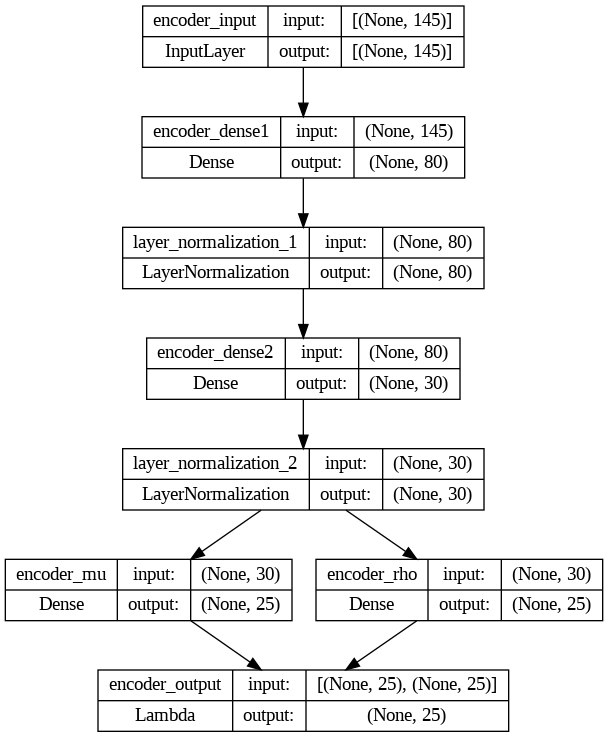

In [23]:
# Encoder
e_x = tensorflow.keras.layers.Input(shape=(num_channels), name="encoder_input")


encoder_dense1 = tensorflow.keras.layers.Dense(units=80,activation='tanh', name="encoder_dense1")(e_x)
encoder_dense1=tensorflow.keras.layers.LayerNormalization(axis=1)(encoder_dense1)
encoder_dense2 = tensorflow.keras.layers.Dense(units=30,activation='tanh', name="encoder_dense2")(encoder_dense1)
encoder_dense2=tensorflow.keras.layers.LayerNormalization(axis=1)(encoder_dense2)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_dense2)
encoder_rho = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_rho")(encoder_dense2)


def sampling_z_only(mu_rho):
        mu,rho=mu_rho
        sd=tensorflow.keras.backend.exp(rho/2);
        z_sample = mu + sd * tensorflow.random.normal(shape=(latent_space_dim,))
        return z_sample



encoder_output = tensorflow.keras.layers.Lambda(sampling_z_only, name="encoder_output")([encoder_mu, encoder_rho])


encoder_mu_rho_model = tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
encoder_final_model = tensorflow.keras.models.Model(e_x, encoder_output, name="encoder_final_model")



# summarize  model
encoder_final_model.summary()
# plot  model
plot_model(encoder_final_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

**Decoder:**

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 25)]              0         
                                                                 
 decoder_dense1 (Dense)      (None, 30)                780       
                                                                 
 layer_normalization_3 (Laye  (None, 30)               60        
 rNormalization)                                                 
                                                                 
 decoder_dense2 (Dense)      (None, 80)                2480      
                                                                 
 layer_normalization_4 (Laye  (None, 80)               160       
 rNormalization)                                                 
                                                                 
 decoder_output (Dense)      (None, 145)             

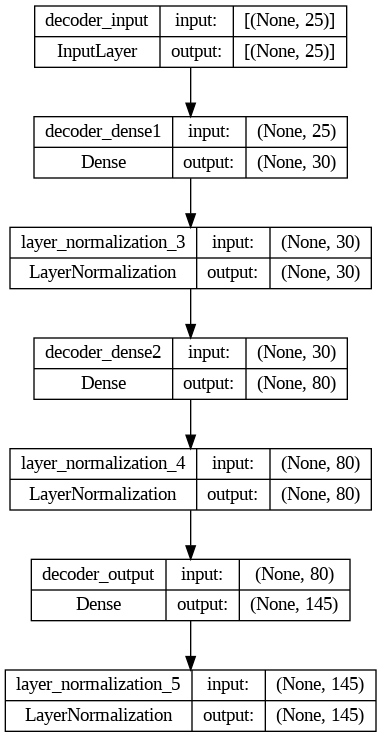

In [24]:
#decoder_input = r_s
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")

decoder_dense1 = tensorflow.keras.layers.Dense(units=30, activation='tanh', name="decoder_dense1")(decoder_input)
decoder_dense1=tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_dense1)
decoder_dense2 = tensorflow.keras.layers.Dense(units=80, activation='tanh', name="decoder_dense2")(decoder_dense1)
decoder_dense2=tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_dense2)
decoder_output = tensorflow.keras.layers.Dense(units=num_channels, name="decoder_output")(decoder_dense2)
decoder_output= tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_output)
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

# summarize  model
decoder.summary()
# plot  model
plot_model(decoder, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)


**Classifiers:**

Model: "c1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c1_input (InputLayer)       [(None, 25)]              0         
                                                                 
 c1_output (Dense)           (None, 12)                312       
                                                                 
Total params: 312
Trainable params: 312
Non-trainable params: 0
_________________________________________________________________


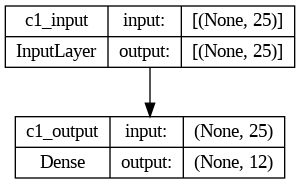

In [25]:
# Classifier1
c1_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="c1_input")
#c1_intermediate1 = tensorflow.keras.layers.Dense(units=50, activation='tanh', kernel_initializer='he_uniform', name="c1_intermediate1")(c1_input)
#c1_intermediate2 = tensorflow.keras.layers.Dense(units=25, activation='tanh', kernel_initializer='he_uniform', name="c1_intermediate2")(c1_intermediate1)
c1_output = tensorflow.keras.layers.Dense(units=num_classes, activation='softmax', name="c1_output")(c1_input)

c1 = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")

# summarize  model
c1.summary()
# plot  model
plot_model(c1, to_file='c1_plot.png', show_shapes=True, show_layer_names=True)

Model: "c2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c2_input (InputLayer)       [(None, 25)]              0         
                                                                 
 c2_output (Dense)           (None, 12)                312       
                                                                 
Total params: 312
Trainable params: 312
Non-trainable params: 0
_________________________________________________________________


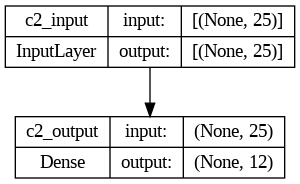

In [26]:
# Classifier2
c2_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="c2_input")
#c2_intermediate1 = tensorflow.keras.layers.Dense(units=50, activation='tanh', kernel_initializer='he_uniform', name="c2_intermediate1")(c2_input)
#c2_intermediate2 = tensorflow.keras.layers.Dense(units=25, activation='tanh', kernel_initializer='he_uniform', name="c2_intermediate2")(c2_intermediate1)
c2_output = tensorflow.keras.layers.Dense(units=num_classes, activation='softmax', name="c2_output")(c2_input)

c2 = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

# summarize  model
c2.summary()
# plot  model
plot_model(c2, to_file='c2_plot.png', show_shapes=True, show_layer_names=True)

**Step 1:**

In [27]:
class step_1_model_class(tfk.Model):

    def __init__(self, dim_z, kl_weight=1, LR_FACTOR=1, name="step_1_model", **kwargs):
        super(step_1_model_class, self).__init__(name=name, **kwargs)
        self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.encoder =   tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
        self.decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
        self.conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")
        self.c1_s = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_s = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")
        self.kl_weight = kl_weight


    def custom_sigmoid_cross_entropy_loss_with_logits(self,x_true, x_recons_logits): # Reconstruction loss In case of Bernoulli distribution assumption
        raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                                            labels=x_true, logits=x_recons_logits)
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=-1)

        return tf.math.reduce_mean(neg_log_likelihood)

    def vae_reconstruction_loss(self,y_true, y_predict):    # Reconstruction loss In case of Gaussian distribution assumption
        reconstruction_loss_factor = 1/2
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-tf.sigmoid(y_predict)), axis=-1)
        reconstruction_loss=tf.math.log(reconstruction_loss*2*math.pi)
        return tensorflow.keras.backend.mean(reconstruction_loss_factor * reconstruction_loss)

    def vae_kl_loss(self,encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=-1)
        return tensorflow.keras.backend.mean(kl_loss)

    def encode(self, x_input):
        mu1,rho1 = self.encoder(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1





    def call(self, x_input):
        conv_out=self.conv_model(x_input)
        z_sample1, mu1, rho1 = self.encode(conv_out)
        x_logits = self.decoder(z_sample1)
        z1_s=self.c1_s(z_sample1)
        z2_s=self.c2_s(z_sample1)
        # Add Losses:
        self.add_loss(LR_loss_factor*self.kl_weight * self.vae_kl_loss(mu1,rho1))
        self.add_loss(LR_loss_factor*self.custom_sigmoid_cross_entropy_loss_with_logits(conv_out,x_logits))
        #self.add_loss(LR_loss_factor*self.vae_reconstruction_loss(conv_out,x_logits2))
        return z1_s,z2_s




In [28]:
    conv_model.trainable = True
    encoder_final_model.trainable = True
    decoder.trainable = True
    c1.trainable = True
    c2.trainable = True

In [29]:
Model_step1 = step_1_model_class(dim_z=latent_space_dim, kl_weight=beta)
Model_step1.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(),
            loss={'output_1':'categorical_crossentropy','output_2':'categorical_crossentropy'},metrics=[tf.keras.metrics.CategoricalAccuracy()])




**Note:**` You can Skip running this snippet and uncomment and run the next snippet instead, in order to load already trained weights for step1:`

In [30]:
## Start Training (Step 1):
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
#mc = ModelCheckpoint('botswana_best_model1_chkp',save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

#Model_step1.fit(source_trainPatches, [source_trainPatches_gt,source_trainPatches_gt], epochs=3000, batch_size=32, shuffle=True,
#                validation_data=(source_testPatches,[source_testPatches_gt,source_testPatches_gt]),
#                callbacks=[es,mc])


##Load the best saved checkpoint
#Model_step1.load_weights('botswana_best_model1_chkp')


In [31]:
# Uncomment these lines to load already trained weights for step 1:

import os

if(os.path.isfile('AlreadyLearnedWeights_botswana_step1.index')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_botswana_step1.index

if(os.path.isfile('AlreadyLearnedWeights_botswana_step1.data-00000-of-00001')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_botswana_step1.data-00000-of-00001

Model_step1.load_weights('AlreadyLearnedWeights_botswana_step1')
Model_step1.save_weights('botswana_best_model1_chkp')


In [32]:
# Evaluate on Target
Model_step1.evaluate(target_patches, [target_patches_gt,target_patches_gt])

52/52 [==============================] - 16s 13ms/step - loss: 2.6870 - output_1_loss: 1.1745 - output_2_loss: 1.1783 - output_1_categorical_accuracy: 0.7738 - output_2_categorical_accuracy: 0.7744


[2.6870462894439697,
 1.1745485067367554,
 1.1782768964767456,
 0.7738022804260254,
 0.774408757686615]

In [33]:
# Evaluate on Source
Model_step1.evaluate(source_patches, [source_patches_gt,source_patches_gt])

36/36 [==============================] - 1s 14ms/step - loss: 0.3474 - output_1_loss: 0.0058 - output_2_loss: 0.0061 - output_1_categorical_accuracy: 0.9991 - output_2_categorical_accuracy: 0.9991


[0.34742745757102966,
 0.005831248592585325,
 0.006126140709966421,
 0.9991304278373718,
 0.9991304278373718]

In [34]:
# Try to find unknowns based on confidence percentage (just for evaluation of this method's performance)

outp1,_=Model_step1.predict(unknown_patches)
outp1_maxes=numpy.amax(outp1,axis=-1)
result=np.where(outp1_maxes<0.5)
len(result[0])
print("The Confidence level for (",len(result[0]),"/",449,"=",len(result[0])*100/449,"% ) of unknowns is below 50%. Other unknowns are classified as known classes with high confidence!")

15/15 [==============================] - 4s 17ms/step
The Confidence level for ( 105 / 449 = 23.385300668151448 % ) of unknowns is below 50%. Other unknowns are classified as known classes with high confidence!


**Step2: Finding Unknowns:**

In [35]:
class recons2_model_class(tfk.Model):

    def __init__(self, dim_z, kl_weight=1, LR_FACTOR=1, name="recons2", **kwargs):
        super(recons2_model_class, self).__init__(name=name, **kwargs)
        self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.encoder =   tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
        self.conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")
        self.decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

        self.conv_model.trainable=False
        self.encoder.trainable=True
        self.decoder.trainable=True



    def vae_reconstruction_loss(self,y_true, y_predict):    # Reconstruction loss In case of Gaussian distribution assumption
        reconstruction_loss_factor = 1/2
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-tf.sigmoid(y_predict)), axis=-1)
        reconstruction_loss=tf.math.log(reconstruction_loss*2*math.pi)
        return (reconstruction_loss_factor * reconstruction_loss)


    def encode(self, x_input):
        mu2,rho2 = self.encoder(x_input)
        sd2=tensorflow.keras.backend.exp(rho2/2);
        z_sample2 = mu2 + sd2 * tf.random.normal(shape=(self.dim_z,))
        return z_sample2





    def call(self, x_input):
        conv_out=self.conv_model(x_input)
        z_sample2 = self.encode(conv_out)
        x_logits2 = self.decoder(z_sample2)
        # Add Losses:
        loss_ae=1*self.vae_reconstruction_loss(conv_out,x_logits2)
        self.add_loss(tensorflow.keras.backend.mean(loss_ae))
        return loss_ae




In [36]:
Model_recons2 = recons2_model_class(dim_z=latent_space_dim, kl_weight=beta)
Model_recons2.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam())

**Note:**` You can Skip running this snippet and uncomment and run the next snippet instead, in order to load already trained weights for step2:`

In [37]:
## Train_Fit
#Model_recons2.fit(source_trainPatches, epochs=1500, batch_size=32, shuffle=True)

In [38]:
# Uncomment these lines to load already trained weights for step 2:

import os

if(os.path.isfile('AlreadyLearnedWeights_botswana_step2.index')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_botswana_step2.index

if(os.path.isfile('AlreadyLearnedWeights_botswana_step2.data-00000-of-00001')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_botswana_step2.data-00000-of-00001

Model_step1.load_weights('AlreadyLearnedWeights_botswana_step2')

In [39]:
# Augmentation

import numpy as np

flipV=np.flip(source_trainPatches,1)
flipH=np.flip(source_trainPatches,2)
flipHV=np.flip(flipH,1)

source_trainPatches_new=np.concatenate((flipV,flipH,flipHV,source_trainPatches),axis=0)
source_trainPatches_new_gt=np.concatenate((source_trainPatches_gt,source_trainPatches_gt,source_trainPatches_gt,source_trainPatches_gt),axis=0)


source_trainPatches_new_gt.shape

(4140, 12)

In [40]:
# histogram high tail Model ( EVA )
loss_hist=Model_recons2.predict(source_trainPatches_new)
loss_hist=loss_hist.astype('double')

mr = libmr.MR()
mr.fit_high(loss_hist,int(0.05*len(source_trainPatches_new)))



130/130 [==============================] - 5s 11ms/step


**Remove Unknowns from target_trainPatches:**

In [41]:
# Predict based on the high tail model
targetpredict=Model_recons2.predict(target_trainPatches)
targetpredict=targetpredict.astype('double')


wscore = mr.w_score_vector(targetpredict)
mask = wscore>TH # The threshold TH


result=np.where(mask == True)
len(result[0])

59/59 [==============================] - 1s 12ms/step


469

In [42]:
# Remove unknowns from target_tarinPatches
target_trainPatches=target_trainPatches[np.where(mask == False)[0],:,:,:]
target_trainPatches_gt=target_trainPatches_gt[np.where(mask == False)[0]]


**Find Unknowns on all target data:**

In [43]:
# Predict based on the high tail model
targetpredict=Model_recons2.predict(target_all)
targetpredict=targetpredict.astype('double')


wscore = mr.w_score_vector(targetpredict)
mask = wscore>TH # The threshold TH


predicted_unknowns_all=np.where(mask == True)
len(predicted_unknowns_all[0])

66/66 [==============================] - 1s 11ms/step


525

In [44]:
# Number of unknowns that are recognized
result2=np.where(target_all_gt[predicted_unknowns_all]==12)
len(result2[0])
print(len(result2[0]),"of 449 unknowns were correctly recognized as unknown.")
print(len(predicted_unknowns_all[0])-len(result2[0]),"of 1649 samples with known classes were falsely recognized as unknows.")

445 of 449 unknowns were correctly recognized as unknown.
80 of 1649 samples with known classes were falsely recognized as unknows.


**Step 3a Model:**

In [45]:
#Load the weights from step 1
Model_step1.load_weights('botswana_best_model1_chkp')


In [46]:
class step_3a_model_class(tfk.Model):

    def __init__(self, dim_z,euclidean_Weight, name="ganb", **kwargs):
        super(step_3a_model_class, self).__init__(name=name, **kwargs)
        self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.euclidean_Weight=euclidean_Weight
        self.encoder =   tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
        self.conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")
        self.c1_st = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_st = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

        self.conv_model.trainable=False
        self.encoder.trainable=False
        self.c1_st.trainable=True
        self.c2_st.trainable=True


    def encode(self, x_input):
        mu,rho = self.encoder(x_input)
        sd=tensorflow.keras.backend.exp(rho/2);
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, rho





    def call(self, x_input):
        input_s,input_t=x_input
        conv_out_s=self.conv_model(input_s)
        conv_out_t=self.conv_model(input_t)
        z_sample_t, mu, rho = self.encode(conv_out_t)
        z_sample_s, mu, rho = self.encode(conv_out_s)
        z1_s=self.c1_st(z_sample_s)
        z2_s=self.c2_st(z_sample_s)
        z1_t=self.c1_st(z_sample_t)
        z2_t=self.c2_st(z_sample_t)
        euclidean_loss=K.sqrt(K.sum(K.square(z1_t - z2_t), axis=-1))
        #euclidean_loss=tf.math.log(euclidean_loss)  ## !
        # Add Loss:
        self.add_loss(-self.euclidean_Weight*tf.math.reduce_mean(euclidean_loss))
        return z1_s,z2_s


In [47]:
    Model_step3a = step_3a_model_class(dim_z=latent_space_dim,euclidean_Weight=alpha)
    Model_step3a.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.00005),
            loss={'output_1':'categorical_crossentropy','output_2':'categorical_crossentropy'}, metrics=[tf.keras.metrics.CategoricalAccuracy()])

**Step 3b Model:**

In [48]:

class step_3b_model_class(tfk.Model):

    def __init__(self, dim_z, name="ganc", **kwargs):
        super(step_3b_model_class, self).__init__(name=name, **kwargs)
        self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.encoder =   tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
        self.conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")
        self.c1_t = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_t = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

        self.conv_model.trainable=True
        self.encoder.trainable=True
        self.c1_t.trainable=False
        self.c2_t.trainable=False


    def encode(self, x_input):
        mu,rho = self.encoder(x_input)
        sd=tensorflow.keras.backend.exp(rho/2);
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, rho





    def call(self, x_input):
        conv_out=self.conv_model(x_input)
        z_sample, mu, rho = self.encode(conv_out)
        z1_t=self.c1_t(z_sample)
        z2_t=self.c2_t(z_sample)
        euclidean_loss=K.sqrt(K.sum(K.square(z1_t - z2_t), axis=-1))
        #euclidean_loss=tf.math.log(euclidean_loss)  ##!
        # Add Loss:
        self.add_loss(tf.math.reduce_mean(euclidean_loss))
        return None


In [49]:
    Model_step3b = step_3b_model_class(dim_z=latent_space_dim)
    Model_step3b.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.00005))


**Train Steps 3a & 3b :**

**Note:**` You can Skip running this snippet and uncomment and run the next snippet instead, in order to load already trained weights for step3:`

In [50]:
## Start Training (Steps 3a & 3b) :

#n_epochs=500
#n_batch=128 # number of samples in each batch
#shuffle_before_each_epoch=True
#early_stop_enabled=True
#max_patience=40


#minimumSampleNumber=min(source_trainPatches_gt.shape[0],target_trainPatches_gt.shape[0])
#int_division=int(minimumSampleNumber/n_batch)
#remainingSamples=minimumSampleNumber-int_division*n_batch
#if(remainingSamples)>0:
#  n_parts=int_division+1
#else:
#  n_parts=int_division

#patience_count=0
#min_bc=float('inf')
#for i in range(n_epochs):
#  gc.collect()
#  print('\n')

#  if(shuffle_before_each_epoch==True):
#    source_trainPatches, source_trainPatches_gt = shuffle(source_trainPatches, source_trainPatches_gt, random_state=42)
#    target_trainPatches, target_trainPatches_gt = shuffle(target_trainPatches, target_trainPatches_gt, random_state=42)
#  for j in range(n_parts):
#    if(j<int_division):
#      source_batch=source_trainPatches[j*n_batch:j*n_batch+n_batch,:,:,:]
#      target_batch=target_trainPatches[j*n_batch:j*n_batch+n_batch,:,:,:]
#      source_batch_gt=source_trainPatches_gt[j*n_batch:j*n_batch+n_batch,:]

#    else:
#      source_batch=source_trainPatches[int_division*n_batch:int_division*n_batch+remainingSamples,:,:,:]
#      target_batch=target_trainPatches[int_division*n_batch:int_division*n_batch+remainingSamples,:,:,:]
#      source_batch_gt=source_trainPatches_gt[int_division*n_batch:int_division*n_batch+remainingSamples,:]



#    if (j==0):
#      should_reset_metrics=True
#    else:
#      should_reset_metrics=False

#    lossb,lossb1,lossb2,acc1,acc2=Model_step3a.train_on_batch([source_batch,target_batch], [source_batch_gt,source_batch_gt],reset_metrics=should_reset_metrics)


#    lossc=Model_step3b.train_on_batch(target_batch,None,reset_metrics=should_reset_metrics)
#    print('\rEpoch '+ str(i+1)+'/'+str(n_epochs)+' Step '+ str(j+1)+ '/'+ str(n_parts)+ ': acc1=', str(acc1)+ ' acc2='+ str(acc2)+' lossb='+str(lossb)+' lossb1='+
#          str(lossb1)+' lossb2='+str(lossb2)+' lossc='+str(lossc), end=''),
#  #Early stopping:
#  if(early_stop_enabled==True):

#    total_lossbc=lossc-lossb # minimizing generator loss and maximizing discriminator loss
#    if(total_lossbc<min_bc):
#      min_bc=total_lossbc
#      patience_count=0
#      Model_step1.save_weights('botswana_best_model3_chkp')
#      print("\nCheckPoint Saved")
#    else:
#      patience_count=patience_count+1;
#      if (patience_count>=max_patience):
#        print("\nEarly Stopping..")
#        break


##Load the best saved checkpoint
#Model_step1.load_weights('botswana_best_model3_chkp')

In [51]:
# Uncomment these lines to load already trained weights for step 3:

import os

if(os.path.isfile('AlreadyLearnedWeights_botswana_step3.index')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_botswana_step3.index

if(os.path.isfile('AlreadyLearnedWeights_botswana_step3.data-00000-of-00001')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_botswana_step3.data-00000-of-00001

Model_step1.load_weights('AlreadyLearnedWeights_botswana_step3')


In [52]:
from sklearn.metrics import classification_report
import numpy as np


y_pred = Model_step1.predict(target_all)
#y_pred = Model_step1.predict(target_patches)
y_pred=np.argmax(y_pred[0],axis=1)
y_pred[predicted_unknowns_all]=12  # predicted unknowns
print(classification_report(target_all_gt,y_pred,digits=3 ))
#print(classification_report(np.argmax(target_patches_gt,axis=1),y_pred,digits=3 ))


66/66 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

         0.0      1.000     0.212     0.349        52
         1.0      0.935     0.951     0.943        61
         2.0      0.990     0.995     0.992       194
         3.0      0.712     1.000     0.832        79
         4.0      0.826     0.884     0.854       199
         5.0      0.929     0.847     0.886       202
         6.0      1.000     0.163     0.280        43
         7.0      1.000     0.896     0.945       135
         8.0      0.988     0.952     0.969       249
         9.0      0.989     0.968     0.978       186
        10.0      0.983     1.000     0.991       233
        11.0      1.000     0.625     0.769        16
        12.0      0.848     0.991     0.914       449

    accuracy                          0.916      2098
   macro avg      0.938     0.806     0.823      2098
weighted avg      0.926     0.916     0.905      2098



/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


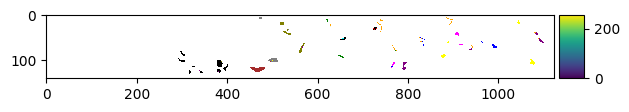

In [53]:
# Final Classification Map

from skimage import io
from skimage import color
from skimage import segmentation
import matplotlib.pyplot as plt
import numpy as np

backgr=np.zeros([1123,140])
seg=np.zeros([1123,140])
for ii in range(len(tp_indexes[0])):
  seg[tp_indexes[0][ii],tp_indexes[1][ii]]=y_pred[ii]+1

for ii in range(len(uk_indexes[0])):
  seg[uk_indexes[0][ii],uk_indexes[1][ii]]=y_pred[ii+len(tp_indexes[0])]+1




# Generate colouring from classification labels
io.imshow(color.label2rgb(seg.transpose(),backgr.transpose(),bg_color=(255,255,255),colors=('red','green','yellow','blue','orange','purple','cyan','magenta','olive','grey','brown','beige','black')
,bg_label=0,alpha=1))
plt.show()

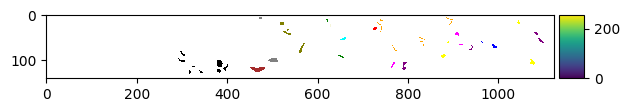

In [54]:
# Ground truth

io.imshow(color.label2rgb(target_gt.transpose(),np.zeros([140,1123]),bg_color=(255,255,255),colors=('red','green','yellow','blue','orange','purple','cyan','magenta','olive','grey','brown','beige','black')
,bg_label=0,alpha=1))
plt.show()


In [55]:
# Save Final Weights
Model_step1.save_weights('botswana_final_weights')
